# Simulate Sequences

In [1]:
### IMPORTS
from simulate import run_simulation

### Run Single Simulation
Commented out, uncomment to use.

In [2]:
# Number of unique monomers
N_MONs = 4

# Molar ratios of each monomer
# ex. if N_MONs = 4: [0.5, 0.25, 0.20, 0.05]
MRs = [50, 25, 20, 5]

# What model of copolymerization to use? (1) mayolewis (terminal) or (2) penultimate
# NOTE FOR NOW ONLY MAYO-LEWIS IMPLEMENTED.
#model = "mayolewis"

# reactivity ratios of monomers, ex. for 4 monomers:
#[r12, r13, r14]
#[r21, r23, r24]
#[r31, r32, r34]
#[r41, r42, r43]
RRs = ([[1, 1, 1, 0.2],
        [1, 1.09, 1.09, 0.2],
        [1, 1.09, 1.09, 0.2],
        [1, 1.09, 1.09, 0.2], 
        [0.2, 0.2, 0.2, 0.2]])

# % conversion targetted (0-1), i.e. how much of the monomer pool do you want to use
conv = 0.5

# average degree of polymerization (chain length) you are targetting at YOUR conversion, NOT at 100%.
avgDP = 50

# number of polymer chains to simulate
N_CHAINs = 10000

# Chain transfer % (0-1)
# TODO: replace this with direct PDI control (not sure how)
# NOTE TO SELF: for now just fix CTP such that PDI ~ 1.2, as thats roughly the control our RAFT synthesis gives.
CTP = 0.15

# cutoff DP of chains considered as polymers not oligomers that get "purified" out
# set to 0 if you don't want to do any filtration
PRUNE_OLIGOMERS = 10

In [3]:
# UNCOMMENT TO USE THIS CODE:
#run_simulation(N_MONs, N_CHAINs, MRs, RRs, avgDP, conv, CTP, PRUNE_OLIGOMERS)

### Run Multiple Simulations

Change the array you want to modify, then also change the array you are looping over in the loop below - be sure to also change what is actually plugged into the equation! 

In [11]:
# Number of unique monomers
#N_MONs = 5
N_MONs = [2,3,4,5]

# Molar ratios of each monomer
# ex. if N_MONs = 4: [0.5, 0.25, 0.20, 0.05]
MRs = [[50, 50, 0, 0, 0], [51, 27, 22, 0, 0], [50, 25, 20, 5, 0], 
       [45, 20, 15, 5, 15]]

# reactivity ratios of monomers, ex. for 4 monomers:
#[r12, r13, r14, r15]
#[r21, r23, r24, r25]
#[r31, r32, r34, r35]
#[r41, r42, r43, r45]
#[r51, r52, r53, r54]
RRs = ([[1, 1, 1, 0.2],
        [1, 1.09, 1.09, 0.2],
        [1, 1.09, 1.09, 0.2],
        [1, 1.09, 1.09, 0.2], 
        [0.2, 0.2, 0.2, 0.2]])

# % conversion targetted (0-1), i.e. how much of the monomer pool do you want to use
conv = 0.5

# average degree of polymerization (chain length) you are targetting at YOUR conversion, NOT at 100%.
#avgDPs = [50, 75, 100, 125, 150, 175, 200, 225, 250]
avgDP = 100

# number of polymer chains to simulate
N_CHAINs = 10000

# Chain transfer % (0-1)
# TODO: replace this with direct PDI control (not sure how)
# NOTE TO SELF: for now just fix CTP such that PDI ~ 1.2, as thats roughly the control our RAFT synthesis gives.
CTP = 0.15

# cutoff DP of chains considered as polymers not oligomers that get "purified" out
# set to 0 if you don't want to do any filtration
PRUNE_OLIGOMERS = 10

In [12]:
for m,n in zip(MRs,N_MONs):
    run_simulation(n, N_CHAINs, m, RRs, avgDP, conv, CTP, PRUNE_OLIGOMERS)

Simulation done! Sequence file saved @ outputs/NM2_MR[50, 50, 0, 0, 0]_NC10000_DP100_conv50_CTP15_FILT10.csv
Simulation done! Sequence file saved @ outputs/NM3_MR[51, 27, 22, 0, 0]_NC10000_DP100_conv50_CTP15_FILT10.csv
Simulation done! Sequence file saved @ outputs/NM4_MR[50, 25, 20, 5, 0]_NC10000_DP100_conv50_CTP15_FILT10.csv
Simulation done! Sequence file saved @ outputs/NM5_MR[45, 20, 15, 5, 15]_NC10000_DP100_conv50_CTP15_FILT10.csv


# Seq Analysis

In [13]:
import pandas as pd
import numpy as np
import glob, os
import csv
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import copy
import csv
from tqdm import tqdm_notebook
from itertools import tee
import re

SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 35

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Load sequence CSV files and set monomer properties
Specify path and what monomers each label corresponds to here (by specifying Mw and HLB)

In [14]:
### IMPORT ALL SEQUENCE CSV FILES IN FOLDER SPECIFIED BY PATH

path = "outputs"
csv_files = []
for file in os.listdir(path):
    if file.endswith("FILT10.csv"):
        csv_files.append(os.path.join(path, file))
csv_files = sorted(csv_files)
print("Number of sequence files:", len(csv_files))
print(csv_files)

### SET MOLECULAR WEIGHTS OF MONOMERS IN ORDER OF LABEL (labels are 1 indexed)
Mw = [100.121,500,198.3,246.32, 104.15]
HLBs = [8.45, 11.42, 5.125, 18.5, 5]

Number of sequence files: 4
['outputs/NM2_MR[50, 50, 0, 0, 0]_NC10000_DP100_conv50_CTP15_FILT10.csv', 'outputs/NM3_MR[51, 27, 22, 0, 0]_NC10000_DP100_conv50_CTP15_FILT10.csv', 'outputs/NM4_MR[50, 25, 20, 5, 0]_NC10000_DP100_conv50_CTP15_FILT10.csv', 'outputs/NM5_MR[45, 20, 15, 5, 15]_NC10000_DP100_conv50_CTP15_FILT10.csv']


### Calculate general sequence statistics and average properties for all sequences by batch
Output is a dataframe with column headers: [Batch Name	NumSeqs	Avg Mn	Avg Mw	PDI	Avg DP]

In [15]:
### CALCULATE AVERAGE DP, Mn, Mw & PDI OF ALL SEQUENCES

names = []
num_seqs = []
avg_Mns = []
avg_Mws = []
PDIs = []
avg_DPs = []
seqs = []

for m in tqdm_notebook(range(len(csv_files))):
    seq = []

    with open(csv_files[m], mode = 'r') as file:
        csvFile = csv.reader(file)
        i = 0
        for lines in csvFile:
            i = i + 1
            seq.append(lines)
    raw_seq = copy.deepcopy(seq)
    seqs.append(raw_seq)
    seqlen = np.zeros(i)
    seqweight = np.zeros(i)
    seqweight2 = np.zeros(i)

    for j in range(0,i):
        seqlen[j] = len(seq[j])
        for k in range(len(seq[j])):
            seq[j][k] = Mw[int(seq[j][k])-1]
        seqweight[j] = sum(seq[j])
        seqweight2[j] = (sum(seq[j])**2)

    AvgMw = sum(seqweight2)/sum(seqweight)
    AvgMn = sum(seqweight)/len(seqweight)
    PDI = AvgMw/AvgMn
    DP = sum(seqlen)/len(seqlen)
    
    names.append(csv_files[m].replace(path, '').replace('/', '').replace('.csv', ''))
    n_mons = []
    MR1s = []
    MR2s = []
    MR3s = []
    MR4s = []
    MR5s = []
    for name in names:
        # n_mons, MR1, ... MRN, n_chains, DP, conv, CTP, Filt
        num_vals = re.findall(r'\d+', name)
        n_mons.append(int(num_vals[0]))
        MR1s.append(int(num_vals[1]))
        MR2s.append(int(num_vals[2]))
        if len(num_vals) > 8:
            MR3s.append(int(num_vals[3]))
        else:
            MR3s.append(0)
        if len(num_vals) > 9:
            MR4s.append(int(num_vals[4]))
        else:
            MR4s.append(0)
        if len(num_vals) > 10:
            MR5s.append(int(num_vals[5]))
        else:
            MR5s.append(0)
    num_seqs.append(i)
    avg_Mns.append(AvgMn)
    avg_Mws.append(AvgMw)
    PDIs.append(PDI)
    avg_DPs.append(DP)
    
d = {'Batch Name': names, 'Mons': n_mons, 'MR1': MR1s, 'MR2': MR2s, 'MR3': MR3s, 'MR4': MR4s, 'MR5': MR5s, 'NumSeqs': num_seqs, 'Avg Mn': avg_Mns, 'Avg Mw': avg_Mws, 'PDI': PDIs, 'Avg DP': avg_DPs}
df_prop = pd.DataFrame(data=d)
df_prop

,Batch Name,Mons,MR1,MR2,MR3,MR4,MR5,NumSeqs,Avg Mn,Avg Mw,PDI,Avg DP
0,"NM2_MR[50, 50, 0, 0, 0]_NC10000_DP100_conv50_C...",2,50,50,0,0,0,9998,30011.872217,33807.658104,1.126476,100.018604
1,"NM3_MR[51, 27, 22, 0, 0]_NC10000_DP100_conv50_...",3,51,27,22,0,0,10000,22892.475802,25775.367231,1.125932,100.000000
2,"NM4_MR[50, 25, 20, 5, 0]_NC10000_DP100_conv50_...",4,50,25,20,5,0,10000,22604.652124,25383.140372,1.122917,100.000000
3,"NM5_MR[45, 20, 15, 5, 15]_NC10000_DP100_conv50...",5,45,20,15,5,15,9999,18977.594025,21366.109486,1.125860,100.009301


In [16]:
#Read csv output files of 'n' batches and convert to n-element pd dataframe
dfs = []
seq_lens = []

for m in range(len(csv_files)):
    seq = []
    row_size = [] 
    
    with open(csv_files[m], mode = 'r') as file:
        csvFile = csv.reader(file)
        i = 0
        for lines in csvFile:
            i = i + 1
            seq.append(lines)
            row_size.append(len(lines))
        df = pd.DataFrame(seq)
        dfs.append(df)
        seq_lens.append(row_size)

dfs[0].head()

,0,1,2,3,4,5,6,7,8,9,...,254,255,256,257,258,259,260,261,262,263
0,1,2,1,1,2,2,2,1,1,2,...,None,None,None,None,None,None,None,None,None,None
1,1,1,1,2,1,1,1,1,1,1,...,None,None,None,None,None,None,None,None,None,None
2,2,2,2,2,2,1,1,2,1,1,...,None,None,None,None,None,None,None,None,None,None
3,1,1,1,2,1,2,1,2,1,2,...,None,None,None,None,None,None,None,None,None,None
4,1,1,1,2,2,1,1,2,2,2,...,None,None,None,None,None,None,None,None,None,None


### Composition Heterogeneity
- mon2mon: visualize sequences simulated (TODO: make this prettier - get code from adv. attack notebook)
- seq2seq: Plot histogram with KDE fit of composition variance per chain around feeding fraction
- batch2batch: nFWHM to compare histograms between batches (normalized full width half maximum: (FWHM = 2*sqrt(2*ln(2))* stdev ~= 2.355*stdev ) & FWHM normalized by feeding fraction)

<Figure size 432x288 with 0 Axes>

<Figure size 4800x160 with 0 Axes>

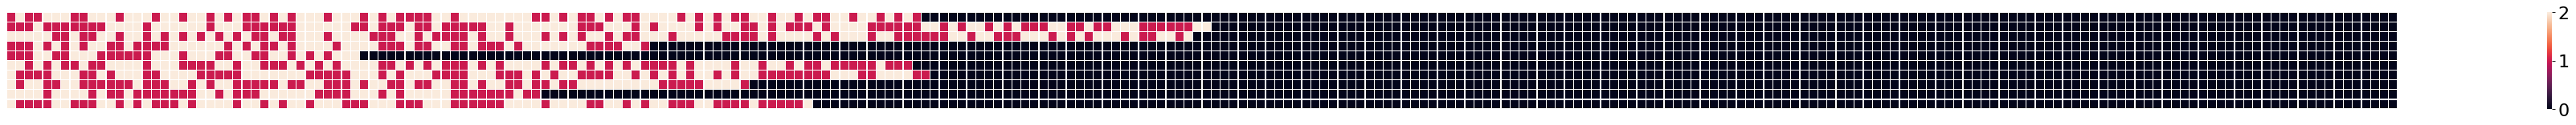

In [19]:
### VISUALIZE SEQUENCE SIMULATED
batch_no = 0
seq_no = 0
num_seqs = 10

chains = []
for i in range(num_seqs):
    chains.append([int(x) if x != None else 0 for x in dfs[batch_no].iloc[seq_no + i]])

plt.cla()   # Clear axis
plt.clf()   # Clear figure
plt.figure(num=None, figsize=(60, 2), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(chains, vmin=0, vmax=df_prop.iloc[batch_no]['Mons'], linewidth=0.2, xticklabels=False, yticklabels=False)
plt.show()
plt.cla()   # Clear axis
plt.clf()   # Clear figure

NM2_MR[50, 50, 0, 0, 0]_NC10000_DP100_conv50_CTP15_FILT10
[0.12593412 0.12593412 0.         0.         0.        ]
[0.25183741 0.25189908 0.         0.         0.        ]


/Users/ivan.jayapurna/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ivan.jayapurna/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 432x288 with 0 Axes>

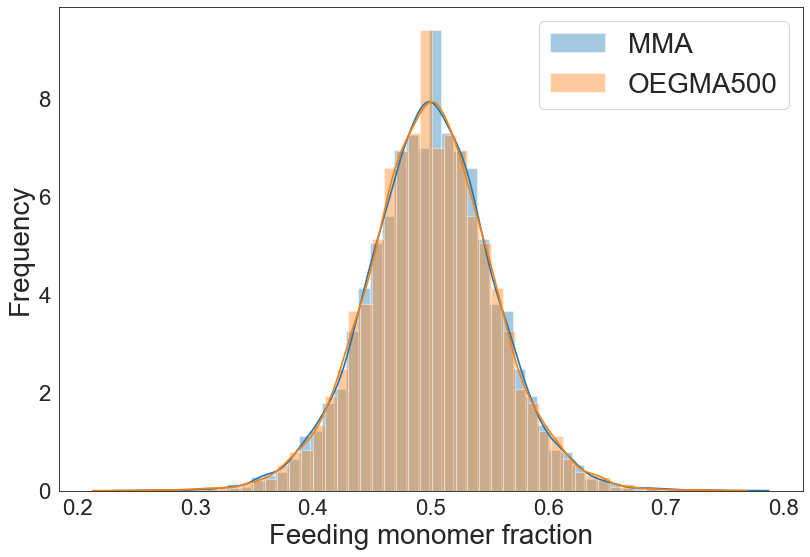

NM3_MR[51, 27, 22, 0, 0]_NC10000_DP100_conv50_CTP15_FILT10
[0.12583127 0.11398487 0.1058398  0.         0.        ]
[0.24511938 0.42435362 0.48540373 0.         0.        ]


/Users/ivan.jayapurna/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ivan.jayapurna/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ivan.jayapurna/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function w

<Figure size 432x288 with 0 Axes>

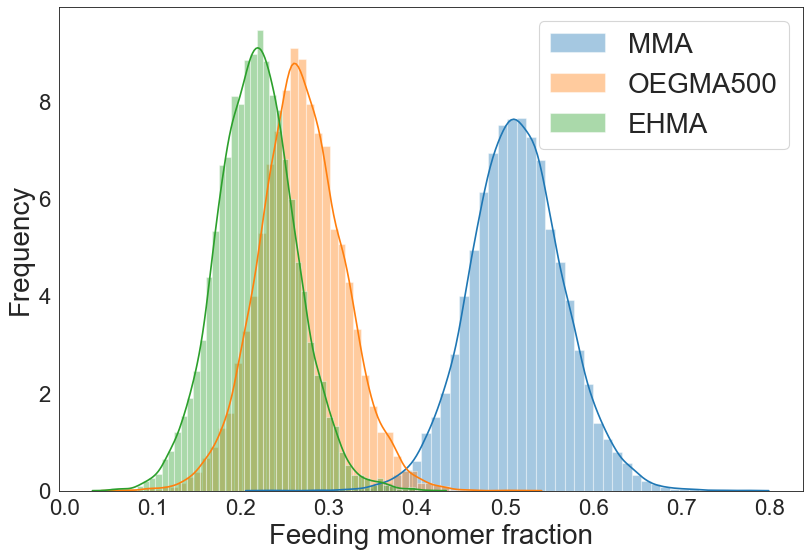

NM4_MR[50, 25, 20, 5, 0]_NC10000_DP100_conv50_CTP15_FILT10
[0.12501635 0.109573   0.10196999 0.05523361 0.        ]
[0.24803273 0.44104029 0.51471447 1.11771969 0.        ]


/Users/ivan.jayapurna/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ivan.jayapurna/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ivan.jayapurna/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function w

<Figure size 432x288 with 0 Axes>

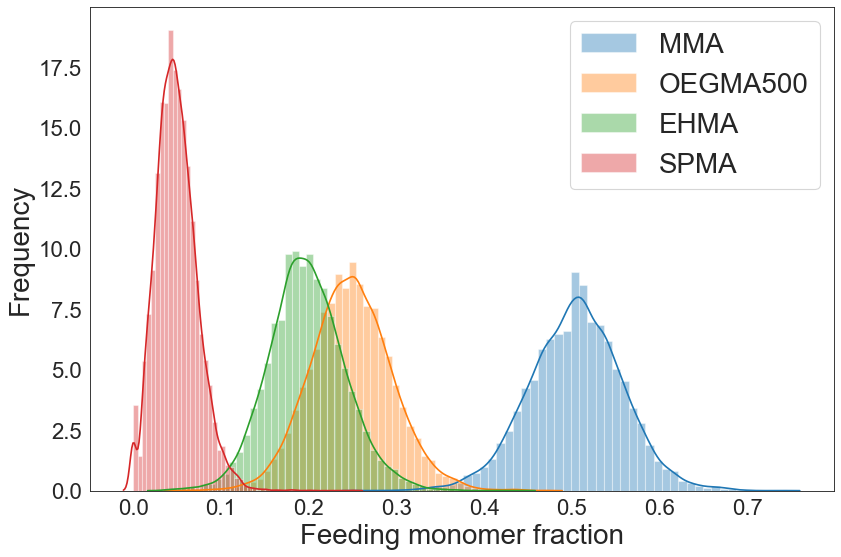

NM5_MR[45, 20, 15, 5, 15]_NC10000_DP100_conv50_CTP15_FILT10
[0.11783835 0.09446282 0.08471649 0.05131752 0.08723467]
[0.29847867 0.54325199 0.6514951  1.19169126 0.3378272 ]


/Users/ivan.jayapurna/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ivan.jayapurna/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ivan.jayapurna/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function w

<Figure size 432x288 with 0 Axes>

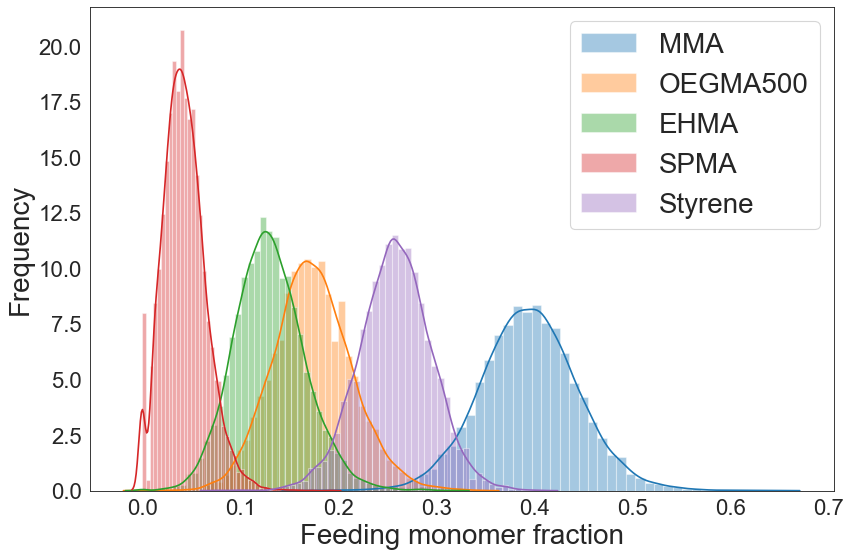

In [33]:
### Histograms of composition on each individual monomer chain:

RUN_ONLY_SUBSET = False # set False if you want to run all sequences
# subset_inds = [0,1]

FWHMs = []
FWHM_norms = []

for m in range(len(csv_files)):
    N_MONS = df_prop['Mons'][m] # number of unique monomers
    seq = []
    
    if RUN_ONLY_SUBSET:
        if m not in subset_inds:
            continue
    
    with open(csv_files[m], mode = 'r') as file:
        csvFile = csv.reader(file)
        i = 0
        for lines in csvFile:
            i = i + 1
            seq.append(lines)

    seqlen = np.zeros(i)
    seq_comp = np.zeros([i,N_MONS])

    for j in range(0,i):
        seqlen[j] = len(seq[j])
        for k in range(N_MONS):
            seq_comp[j][k] = seq[j].count(str(k+1))/seqlen[j]
            
    print(csv_files[m].replace(path, '').replace('/', '').replace('.csv', ''))
    FWHM = np.zeros(5)
    FWHM_norm = np.zeros(5)
    for i in range(N_MONS):
        #MMA_x, MMA_y = sns.distplot(seq_comp[:,0], label="MMA").get_lines()[0].get_data()
        FWHM[i] = 2.355*np.std(seq_comp[:,i])
        FWHM_norm[i] = 2.355*np.std(seq_comp[:,i])/np.mean(seq_comp[:,i])
    print(FWHM)
    print(FWHM_norm)
    FWHMs.append(FWHM)
    FWHM_norms.append(FWHM_norm)

    plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
    sns.set_style(style='white') #style='white' or 'darkgrid'
    plt.xlabel("Feeding monomer fraction")
    plt.ylabel("Frequency")
    sns.distplot(seq_comp[:,0], label="MMA")
    sns.distplot(seq_comp[:,1], label="OEGMA500")
    if N_MONS > 2:
        sns.distplot(seq_comp[:,2], label="EHMA")
    if N_MONS > 3:
        sns.distplot(seq_comp[:,3], label="SPMA")
    if N_MONS == 5:
        sns.distplot(seq_comp[:,4], label="Styrene")
    plt.legend()
    plt.show()

    plt.cla()   # Clear axis
    plt.clf()   # Clear figure

    """ # (same plot but using plt instead of sns)
    plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
    plt.xlabel("chain composition fraction", fontsize=15)
    #plt.ylabel("asdf")
    plt.hist(seq_comp[:,0], label="MMA")
    plt.hist(seq_comp[:,1], label="OEGMA500")
    plt.hist(seq_comp[:,2], label="EHMA")
    plt.hist(seq_comp[:,3], label="SPMA")
    plt.legend(fontsize=15)
    plt.show()
    """

FWHMs = np.array(FWHMs)
FWHM_norms = np.array(FWHM_norms)

<Figure size 432x288 with 0 Axes>

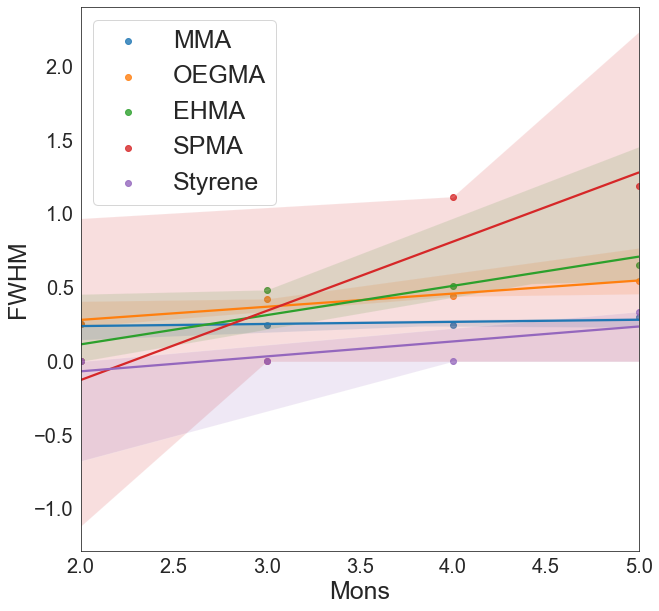

In [35]:
for i in range(5):
    df_prop['FWHM_' + str(i)] = FWHM_norms[:,i]
    
plt.cla()   # Clear axis
plt.clf()   # Clear figure
fig, ax = plt.subplots(1, 1, figsize=(10,10))
sns.set_style(style='white') #style='white' or 'darkgrid'
ax = sns.regplot(x="Mons", y="FWHM_0", data=df_prop, label='MMA')
ax = sns.regplot(x="Mons", y="FWHM_1", data=df_prop, label='OEGMA')
ax = sns.regplot(x="Mons", y="FWHM_2", data=df_prop, label='EHMA') 
ax = sns.regplot(x="Mons", y="FWHM_3", data=df_prop, label='SPMA')
ax = sns.regplot(x="Mons", y="FWHM_4", data=df_prop, label='Styrene')
ax.set_ylabel('FWHM')
#ax.set(ylim=(0, 1))
plt.legend(loc='best')
plt.show()

### Hydrophilic & Hydrophobic Segments
- mon2mon: Visualize hydrophobic & hydrophilic segments along a chain?
- seq2seq: box-whisker of avg'd per chain proerties (NOTE: we don't actually need the batch summed statistics (histogram) for this level - its only good to compare across levels)
- batch2batch: lineplot of summed histograms (summed statistics) with 1 line for each batch.

In [36]:
# EXTRA PARAM: determines what is considered hydrophobic and what is considered hydrophilic
# Anything less than or equal to HLB_CUTOFF is considered hydrophobic.
HLB_CUTOFF = 9

<Figure size 432x288 with 0 Axes>

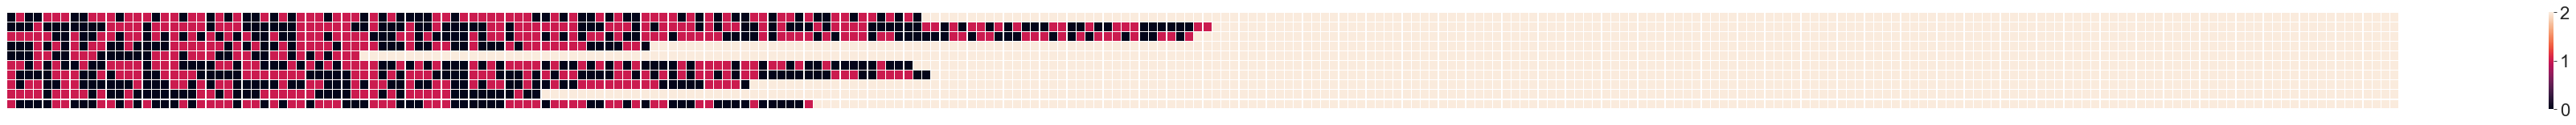

In [37]:
### VISUALIZE HYDROPHLIC & HYDROPHOBIC SEGMENTS
# go through each sequence specified and BINARIZE based on HLB_CUTOFF, then visualize. 
batch_ind = 0
seq_no = 0
num_seqs = 10

cols_size = len(dfs[batch_ind].columns)
binarized_chains = []
for i in range(num_seqs):
    binarized_seq = []
    for j in range(cols_size):
        this_mon = dfs[batch_ind][j][i]
        if this_mon is None:
            binarized_seq.append(2)
        elif HLBs[int(this_mon)-1] <= HLB_CUTOFF:
            binarized_seq.append(0)
        else:
            binarized_seq.append(1)
    binarized_chains.append(binarized_seq)

plt.cla()   # Clear axis
plt.clf()   # Clear figure
plt.figure(num=None, figsize=(60, 2), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(binarized_chains, vmin=0, vmax=2, linewidth=0.2, xticklabels=False, yticklabels=False)
plt.show()
plt.cla()   # Clear axis
plt.clf()   # Clear figure


In [62]:
#SEQ2SEQ NEW ANALYSIS DATA

b_no = 2

rows_size = len(dfs[b_no])
cols_size = len(dfs[b_no].columns)

hydrophob_li = list()
hydrophil_li = list()

for i in tqdm_notebook(range(rows_size)):
    hydrophobl = np.zeros(cols_size)
    hydrophilbl = np.zeros(cols_size)
    counterpho = 0
    counterphil = 0
    for j in range(cols_size):
        if dfs[b_no][j][i] == None:
            if counterpho > 0:
                hydrophobl[counterpho-1] += 1
            if counterphil > 0:
                hydrophilbl[counterphil-1] += 1
            break
        elif HLBs[int(dfs[b_no][j][i])-1] <= HLB_CUTOFF:
            counterpho += 1
            if counterphil > 0:
                hydrophilbl[counterphil-1] += 1
            counterphil = 0
            continue
        else:
            counterphil += 1
            if counterpho > 0:
                hydrophobl[counterpho-1] += 1
            counterpho = 0
            continue

    hydrophob_li.append(hydrophobl)
    hydrophil_li.append(hydrophilbl)

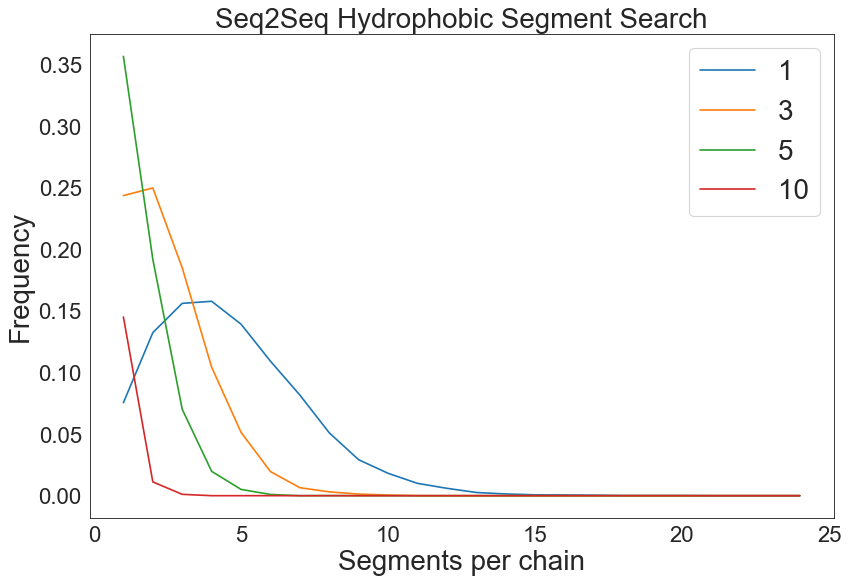

<Figure size 432x288 with 0 Axes>

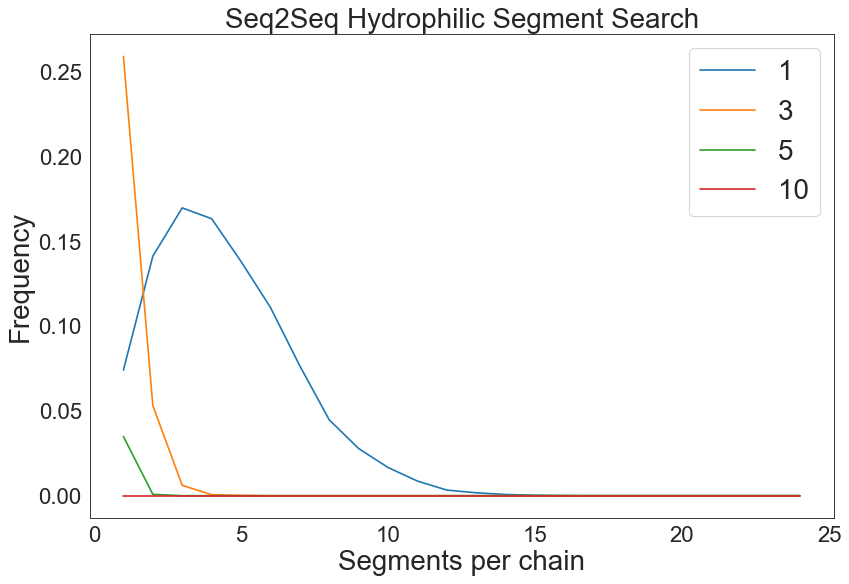

In [63]:
#SEQ2SEQ PLOTTING: HYDROPHOBIC
## IF THROWS ERROR CHANGE RANGE OF PHOB AND PHIL A-D
num_a = 1
num_b = 3
num_c = 5
num_d = 10

array = []
PHOB_A = np.zeros(25) # NOTE 25 IS A MAGIC NUMBER THAT NEEDS TO BE REPLACED
PHOB_B = np.zeros(25) # WAY TOO HIGH UPPER BOUND IS NP.MAX(HYDROPHOB_LI)
PHOB_C = np.zeros(25) # need to code a tighter bound.
PHOB_D = np.zeros(25)
for i in range(len(hydrophob_li)):
    if hydrophob_li[i][num_a] != 0:
        PHOB_A[int(hydrophob_li[i][num_a])] += 1
    if hydrophob_li[i][num_b] != 0:
        PHOB_B[int(hydrophob_li[i][num_b])] += 1
    if hydrophob_li[i][num_c] != 0:
        PHOB_C[int(hydrophob_li[i][num_c])] += 1
    if hydrophob_li[i][num_d] != 0:
        PHOB_D[int(hydrophob_li[i][num_d])] += 1

PHOB_A = PHOB_A[1:len(PHOB_A)]
PHOB_B = PHOB_B[1:len(PHOB_B)]
PHOB_C = PHOB_C[1:len(PHOB_C)]
PHOB_D = PHOB_D[1:len(PHOB_D)]

plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
# sns.set_style(style='white') #style='white' or 'darkgrid'
plt.xlabel("Segments per chain")
plt.ylabel("Frequency")
sns.set_style(style = 'white')
sns.lineplot(x = np.array(np.linspace(1, len(PHOB_A), num = len(PHOB_A))), y = PHOB_A/df_prop['NumSeqs'][b_no], label = str(num_a))
sns.lineplot(x = np.array(np.linspace(1, len(PHOB_B), num = len(PHOB_B))), y = PHOB_B/df_prop['NumSeqs'][b_no], label = str(num_b))
sns.lineplot(x = np.array(np.linspace(1, len(PHOB_C), num = len(PHOB_C))), y = PHOB_C/df_prop['NumSeqs'][b_no], label = str(num_c))
sns.lineplot(x = np.array(np.linspace(1, len(PHOB_D), num = len(PHOB_D))), y = PHOB_D/df_prop['NumSeqs'][b_no], label = str(num_d))
plt.legend()
plt.title("Seq2Seq Hydrophobic Segment Search")
plt.show()
plt.cla()
plt.clf()

#SEQ2SEQ PLOTTING: HYDROPHILIC
array = []
PHIL_A = np.zeros(25)
PHIL_B = np.zeros(25)
PHIL_C = np.zeros(25)
PHIL_D = np.zeros(25)
for i in range(len(hydrophil_li)):
    if hydrophil_li[i][num_a] != 0:
        PHIL_A[int(hydrophil_li[i][num_a])] += 1
    if hydrophil_li[i][num_b] != 0:
        PHIL_B[int(hydrophil_li[i][num_b])] += 1
    if hydrophil_li[i][num_c] != 0:
        PHIL_C[int(hydrophil_li[i][num_c])] += 1
    if hydrophil_li[i][num_d] != 0:
        PHIL_D[int(hydrophil_li[i][num_d])] += 1

PHIL_A = PHIL_A[1:len(PHIL_A)]
PHIL_B = PHIL_B[1:len(PHIL_B)]
PHIL_C = PHIL_C[1:len(PHIL_C)]
PHIL_D = PHIL_D[1:len(PHIL_D)]

plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
# sns.set_style(style='white') #style='white' or 'darkgrid'
plt.xlabel("Segments per chain")
plt.ylabel("Frequency")
sns.set_style(style = 'white')
sns.lineplot(x = np.array(np.linspace(1, len(PHIL_A), num = len(PHIL_A))), y = PHIL_A/df_prop['NumSeqs'][b_no], label = str(num_a))
sns.lineplot(x = np.array(np.linspace(1, len(PHIL_B), num = len(PHIL_B))), y = PHIL_B/df_prop['NumSeqs'][b_no], label = str(num_b))
sns.lineplot(x = np.array(np.linspace(1, len(PHIL_C), num = len(PHIL_C))), y = PHIL_C/df_prop['NumSeqs'][b_no], label = str(num_c))
sns.lineplot(x = np.array(np.linspace(1, len(PHIL_D), num = len(PHIL_D))), y = PHIL_D/df_prop['NumSeqs'][b_no], label = str(num_d))
plt.legend()
plt.title("Seq2Seq Hydrophilic Segment Search")
plt.show()

In [ ]:
# OLD BOX WHISKER PLOT COMMENTED OUT.
"""
### FULL HYDROPHOBIC DATASET (non-zero)
phobic_length_data = []
for i in range(len(graph1_phob)):
    phobic_length_data.append([ y_ for y_ in list(hydrophobic_df[i]) if y_ != 0.0])
        
fig = plt.figure(figsize =(12, 7))
#ax = fig.add_axes([0, 1, 2, 1])
ax = fig.add_axes([0, 0, 1, 1])
ax.boxplot(phobic_length_data, whis=(0,100))
plt.xlabel("Hydrophobic Segment Length")
plt.ylabel("Non-zero counts")
#plt.xticks([])
#plt.xticks(np.arange(0,cols_size, step=20)) #TODO: fix x axis marks
plt.show()

#  just hydrophobic segment lengths up to 10
phobic_length_data2 = []
for i in range(12):
    phobic_length_data2.append([ y_ for y_ in list(hydrophobic_df[i]) if y_ != 0.0])

fig = plt.figure(figsize =(12, 7))
#ax2 = fig.add_axes([0, 0, 2, 1])
ax = fig.add_axes([0, 0, 1, 1])
ax.boxplot(phobic_length_data2, whis=(0,100))
plt.xlabel("Hydrophobic Segment Length")
plt.ylabel("Non-zero counts")
#plt.xticks([])
#plt.xticks(np.arange(0,cols_size, step=20)) #TODO: fix x axis marks
plt.show()

### FULL HYDROphilic DATASET (non-zero)
philic_length_data = []
for i in range(len(graph1_phil)):
    philic_length_data.append([ y_ for y_ in list(hydrophilic_df[i]) if y_ != 0.0])
        
fig = plt.figure(figsize =(12, 7))
#ax = fig.add_axes([0, 1, 2, 1])
ax = fig.add_axes([0, 0, 1, 1])
ax.boxplot(philic_length_data, whis=(0,100))
plt.xlabel("Hydrophilic Segment Length")
plt.ylabel("Non-zero counts")
#plt.xticks([])
#plt.xticks(np.arange(0,cols_size, step=20)) #TODO: fix x axis marks

#  just hydrophilic segment lengths up to 10
philic_length_data2 = []
for i in range(12):
    philic_length_data2.append([ y_ for y_ in list(hydrophilic_df[i]) if y_ != 0.0])

fig = plt.figure(figsize =(12, 7))
#ax2 = fig.add_axes([0, 0, 2, 1])
ax = fig.add_axes([0, 0, 1, 1])
ax.boxplot(philic_length_data2, whis=(0,100))
plt.xlabel("Hydrophilic Segment Length")
plt.ylabel("Non-zero counts")
#plt.xticks([])
#plt.xticks(np.arange(0,cols_size, step=20)) #TODO: fix x axis marks
plt.show()
""";

/Users/ivan.jayapurna/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/ivan.jayapurna/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/ivan.jayapurna/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterp

<Figure size 432x288 with 0 Axes>

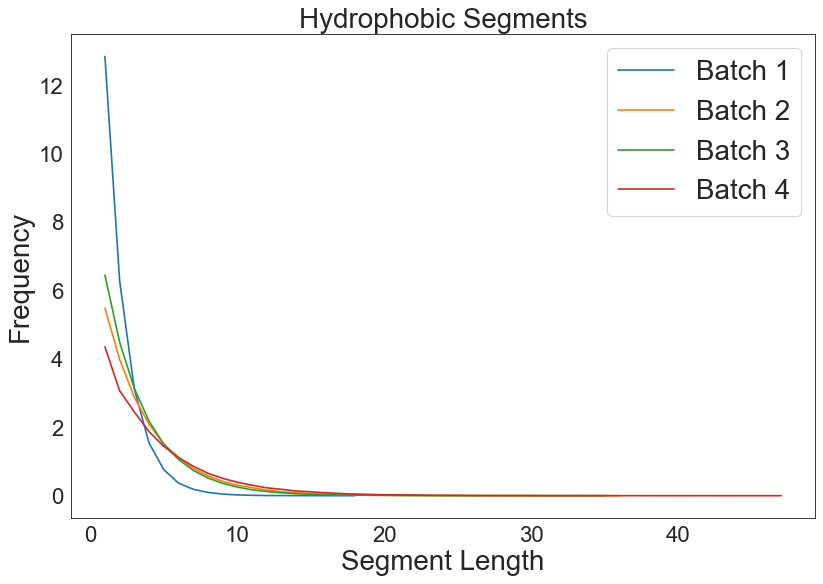

/Users/ivan.jayapurna/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/ivan.jayapurna/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/ivan.jayapurna/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterp

<Figure size 432x288 with 0 Axes>

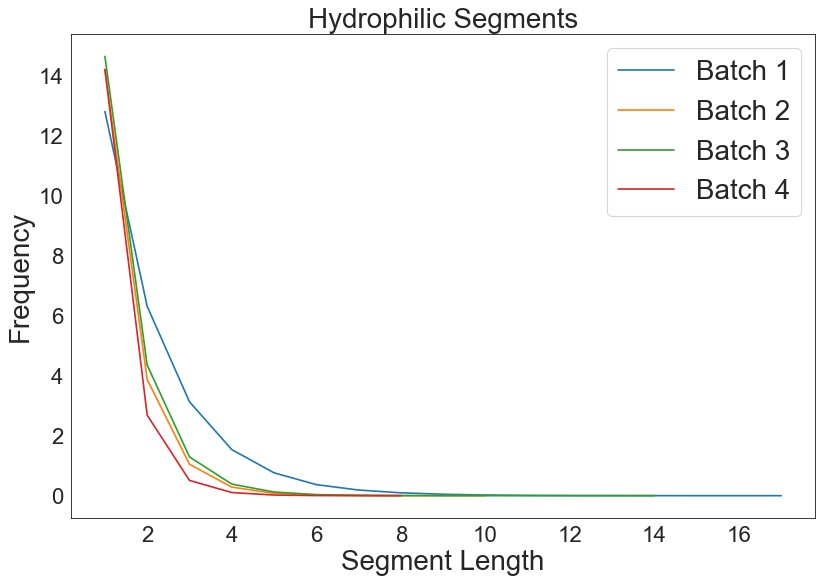

In [65]:
# BATCH SUMMED STATISTICS FOR HYDROPHILIC & HYDROPHOBIC SEGMENTS
x_phob_all = []
x_phil_all = []
graph_phob_all = []
graph_phil_all = []
for batch_ind in tqdm_notebook(range(len(csv_files))):

    rows_size = len(dfs[batch_ind])
    #print("rows size:", rows_size)
    cols_size = len(dfs[batch_ind].columns)
    #print("cols size:", cols_size)
    
    # count the hydrophilic and hydrophobic segments
    hydrophob_li = list()
    hydrophil_li = list()
    for i in tqdm_notebook(range(rows_size)):
        hydrophobl = np.zeros(cols_size)
        hydrophilbl = np.zeros(cols_size)
        counterpho = 0
        counterphil = 0
        for j in range(cols_size):
            if dfs[batch_ind][j][i] == None:
                if counterpho > 0:
                    hydrophobl[counterpho-1] += 1
                if counterphil > 0:
                    hydrophilbl[counterphil-1] += 1
                break
            elif HLBs[int(dfs[batch_ind][j][i])-1] <= HLB_CUTOFF:
                counterpho += 1
                if counterphil > 0:
                    hydrophilbl[counterphil-1] += 1
                counterphil = 0
                continue
            else:
                counterphil += 1
                if counterpho > 0:
                    hydrophobl[counterpho-1] += 1
                counterpho = 0
                continue

        hydrophob_li.append(hydrophobl)
        hydrophil_li.append(hydrophilbl)

    hydrophobic_df = pd.DataFrame(hydrophob_li)
    hydrophilic_df = pd.DataFrame(hydrophil_li)

    # Sum the segment counts
    graph1_phob = np.array(hydrophobic_df.sum(axis=0))
    graph1_phil = np.array(hydrophilic_df.sum(axis=0))

    # go backwards from both until you find the first non-zero entry and truncate there
    for i in range(1,len(graph1_phob)):
        if (graph1_phob[-i] != 0.0):
            graph1_phob = graph1_phob[:(-i+1)]
            break

    for i in range(1,len(graph1_phil)):
        if (graph1_phil[-i] != 0.0):
            graph1_phil = graph1_phil[:(-i+1)]
            break

            
    # create x-axis for both
    x_phob_1 = np.arange(1,len(graph1_phob)+1)
    x_phil_1 = np.arange(1,len(graph1_phil)+1)
    x_phob_all.append(x_phob_1)
    x_phil_all.append(x_phil_1)
    graph_phob_all.append(graph1_phob)
    graph_phil_all.append(graph1_phil)
    
    
#     # PLOT hydrophobic & hydrophilic segments
#     plt.cla()   # Clear axis
#     plt.clf()   # Clear figure
    
#     fig = plt.figure()
#     ax = fig.add_axes([0,0,1,1])
#     ax.bar(x_phob_1,graph1_phob, width = 1)
#     plt.xlabel("Hydrophobic Segment Length")
#     plt.ylabel("Number of Hydrophobic Segments")

#     plt.title("Batch " + str(batch_ind))
#     plt.show()
#     plt.cla()   # Clear axis
#     plt.clf()   # Clear figure

#     fig = plt.figure()
#     ax = fig.add_axes([0,0,1,1])
#     ax.bar(x_phil_1,graph1_phil, width = 1)
#     plt.xlabel("Hydrophilic Segment Length")
#     plt.ylabel("Number of Hydrophilic Segments")

#     plt.title("Batch " + str(batch_ind))
#     plt.show()
#     plt.cla()   # Clear axis
#     plt.clf()   # Clear figure
    
#     plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
#     sns.set_style(style='white') #style='white' or 'darkgrid'
#     plt.xlabel("Segment Length")
#     plt.ylabel("Counts")
#     sns.lineplot(x_phob_1, graph1_phob, label="hydrophobic")
#     plt.legend()
#     plt.show()
#     plt.cla()   # Clear axis
#     plt.clf()   # Clear figure

# LINE PLOTS ACROSS BATCHES: HYDROPHOBIC
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
sns.set_style(style='white') #style='white' or 'darkgrid'
plt.xlabel("Segment Length")
plt.ylabel("Frequency")
#Comment following 2 lines to remove autolabelling
for i in range(len(csv_files)):
    sns.lineplot(x_phob_all[i], graph_phob_all[i]/df_prop['NumSeqs'][b_no], label="Batch "+str(i+1))
## Uncomment the following lines to manually label
# sns.lineplot(x_phob_all[0], graph_phob_all[0], label="5 Monomers")
# sns.lineplot(x_phob_all[1], graph_phob_all[1], label="4 Monomers")
# sns.lineplot(x_phob_all[2], graph_phob_all[2], label="2 Monomers")
# sns.lineplot(x_phob_all[3], graph_phob_all[3], label="3 Monomers")
plt.legend()
plt.title("Hydrophobic Segments")
plt.show()
plt.cla()
plt.clf()

# LINE PLOTS ACROSS BATCHES: HYDROPHILIC
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
sns.set_style(style='white') #style='white' or 'darkgrid'
plt.xlabel("Segment Length")
plt.ylabel("Frequency")
#Comment following 2 lines to remove autolabelling
for i in range(len(csv_files)):
    sns.lineplot(x_phil_all[i], graph_phil_all[i]/df_prop['NumSeqs'][b_no], label="Batch "+str(i+1))
## Uncomment the following lines to manually label
# sns.lineplot(x_phil_all[0], graph_phil_all[0], label="5 Monomers")
# sns.lineplot(x_phil_all[1], graph_phil_all[1], label="4 Monomers")
# sns.lineplot(x_phil_all[2], graph_phil_all[2], label="2 Monomers")
# sns.lineplot(x_phil_all[3], graph_phil_all[3], label="3 Monomers")
plt.legend()
plt.title("Hydrophilic Segments")
plt.show()
plt.cla()
plt.clf()

### Specific Segment Search
Customizable section to find specific pattern i.e. right now the implementation looks for hydrophobic segments containing 1 OEGMA as the hypothesis are that these segments are key for proton transport. Another example (not implemented) could be looking at the flanking regions of a specific monomer and analyzing the composition.
- mon2mon: find patterns on a single chain
- seq2seq: box-whisker of distribution of patterns per chain and batch summed statistics (histogram)
- batch2batch: (TODO) plot multiple histograms either on the same plot/axes with seethrough/opaque bars cuz they’ll be overlapping —> just have a bold line of best fit overlaying the top of the histogram —> replace with sns.distplot like we did for the composition histograms.

In [143]:
this_mon = dfs[1][116][1]
print(this_mon)
this_mon == None

None


True

In [146]:
#specific segment pattern search
b_no = 1
s_no = 1

oegma_counter = 0
seg_len = 0
seg_array = []

for i in range(len(dfs[b_no].iloc[s_no])):
    this_mon = dfs[b_no][i][s_no]
    if this_mon == None:
        break
    elif int(this_mon) == 2:
        back_counter = 0
        forward_counter = 0
        j = 1
        k = 1
        while (i-j >= 0) and (dfs[b_no][i-j][s_no] != None) and (HLBs[int(dfs[b_no][i-j][s_no])-1] <= HLB_CUTOFF):
            j += 1
            back_counter += 1
        while (i+k <= len(dfs[b_no].iloc[s_no])-1) and (dfs[b_no][i+k][s_no] != None) and (HLBs[int(dfs[b_no][i+k][s_no])-1] <= HLB_CUTOFF):
            k += 1
            forward_counter += 1
        if forward_counter > 1 and back_counter > 1:
            seg_array.append(back_counter + forward_counter + 1)

if len(seg_array) == 0:
    print('0 patterns found.')
else:
    print('Number of Hydrophobic segments with 1 OEGMA: ' + str(len(seg_array)))
    print('Length of Hydrophobic segments with 1 OEGMA: ' + str(seg_array))

Number of Hydrophobic segments with 1 OEGMA: 6
Length of Hydrophobic segments with 1 OEGMA: [14, 14, 10, 7, 16, 10]


In [148]:
### Specific segment pattern search (seq2seq level)
#b_no = batch_no - 1
total_array = []
total_seg_len = []
total_seg_array = []

#if taking too long to run, remove 100k file by changing line to:
#for b_no in tqdm_notebook(range(1, len(csv_files))):
for b_no in tqdm_notebook(range(len(csv_files))):
    oegma_counter = 0
    seg_len_list = []
    seg_array_b = []
    seg_arr = []
    allseg_array = []

    for s_no in tqdm_notebook(range(len(dfs[b_no]))):
        seg_arr = []
        for i in range(len(dfs[b_no].iloc[s_no])):
            this_mon = dfs[b_no][i][s_no]
            if this_mon == None:
                break
            elif int(this_mon) == 2:
                back_counter = 0
                forward_counter = 0
                j = 1
                k = 1
                while (i-j >= 0) and (dfs[b_no][i-j][s_no] != None) and (HLBs[int(dfs[b_no][i-j][s_no])-1] <= HLB_CUTOFF):
                    j += 1
                    back_counter += 1
                while (i+k <= len(dfs[b_no].iloc[s_no])-1) and (dfs[b_no][i+k][s_no] != None) and (HLBs[int(dfs[b_no][i+k][s_no])-1] <= HLB_CUTOFF):
                    k += 1
                    forward_counter += 1
                if forward_counter > 1 and back_counter > 1:
                    seg_arr.append(back_counter + forward_counter + 1)
                    allseg_array.append(back_counter + forward_counter + 1)
        seg_len_list.append(len(seg_arr))
        seg_array_b.append(seg_arr)
    
    total_array.append(allseg_array)
    total_seg_len.append(seg_len_list)
    total_seg_array.append(seg_array_b)

#seg_array_b --> list of lengths of Hydrophobic segments with 1 OEGMA per sequence in specified batch
#seg_len_list --> array of number of Hydrophobic segments with 1 OEGMA per sequence in specified batch
 

[6316. 2495.  842.  261.   72.   11.]
[4655. 3271. 1403.  501.  119.   40.    7.]
[5448. 3141. 1029.  319.   50.   12.]
[6.899e+03 2.472e+03 5.290e+02 9.300e+01 6.000e+00]


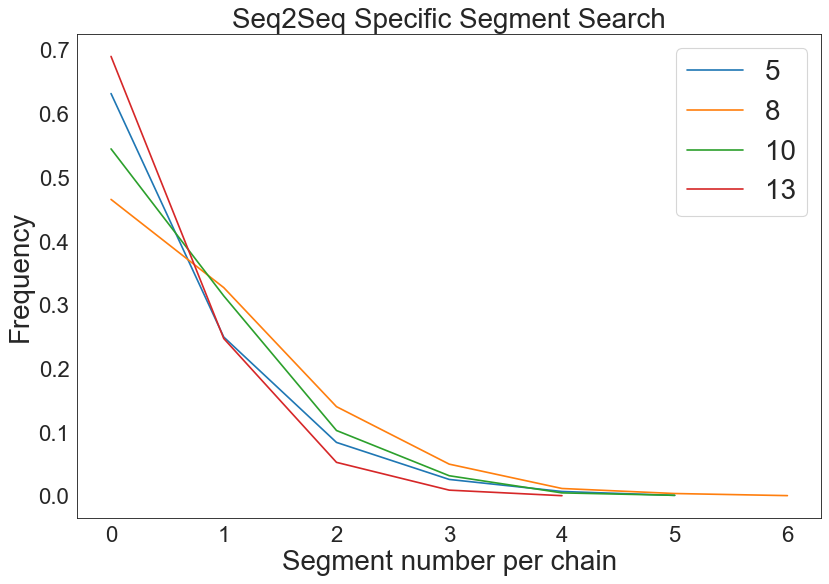

In [149]:
b_no = 1
ARR_5 = []
ARR_8 = []
ARR_10 = []
ARR_13 = []

for seq in range(len(total_seg_array[b_no])):
    entry_5 = 0
    entry_8 = 0
    entry_10 = 0
    entry_13 = 0
    for lens in range(len(total_seg_array[b_no][seq])):
        if total_seg_array[b_no][seq][lens] == 5:
            entry_5 += 1
        elif total_seg_array[b_no][seq][lens] == 8:
            entry_8 += 1
        elif total_seg_array[b_no][seq][lens] == 10:
            entry_10 += 1
        elif total_seg_array[b_no][seq][lens] == 13:
            entry_13 += 1
    ARR_5.append(entry_5)
    ARR_8.append(entry_8)
    ARR_10.append(entry_10)
    ARR_13.append(entry_13)
    
        
data_5 = np.zeros(max(ARR_5))
for i in range(len(ARR_5)):
    for j in range(max(ARR_5)):
        if ARR_5[i] == j:
            data_5[j] += 1
            
data_8 = np.zeros(max(ARR_8))
for i in range(len(ARR_8)):
    for j in range(max(ARR_8)):
        if ARR_8[i] == j:
            data_8[j] += 1
            
data_10 = np.zeros(max(ARR_10))
for i in range(len(ARR_10)):
    for j in range(max(ARR_10)):
        if ARR_10[i] == j:
            data_10[j] += 1
            
data_13 = np.zeros(max(ARR_13))
for i in range(len(ARR_13)):
    for j in range(max(ARR_13)):
        if ARR_13[i] == j:
            data_13[j] += 1

print(data_5)
print(data_8)
print(data_10)
print(data_13)

plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
# sns.set_style(style='white') #style='white' or 'darkgrid'
plt.xlabel("Segment number per chain")
plt.ylabel("Frequency")
sns.set_style(style = 'white')
sns.lineplot(x = np.array(np.linspace(0, len(data_5)-1, num = len(data_5))), y = data_5/df_prop['NumSeqs'][b_no], label = "5")
sns.lineplot(x = np.array(np.linspace(0, len(data_8)-1, num = len(data_8))), y = data_8/df_prop['NumSeqs'][b_no], label = "8")
sns.lineplot(x = np.array(np.linspace(0, len(data_10)-1, num = len(data_10))), y = data_10/df_prop['NumSeqs'][b_no], label = "10")
sns.lineplot(x = np.array(np.linspace(0, len(data_13)-1, num = len(data_13))), y = data_13/df_prop['NumSeqs'][b_no], label = "13")
plt.legend()
plt.title("Seq2Seq Specific Segment Search")
plt.show()


Average Number of Hydrophobic segments with 1 Oegma per sequence in batch: 6.337333733373337
StDev of Number of Hydrophobic segments with 1 Oegma per sequence in batch: 3.1970829619638805


/Users/ivan.jayapurna/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/ivan.jayapurna/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/Users/ivan.jayapurna/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level 

<Figure size 432x288 with 0 Axes>

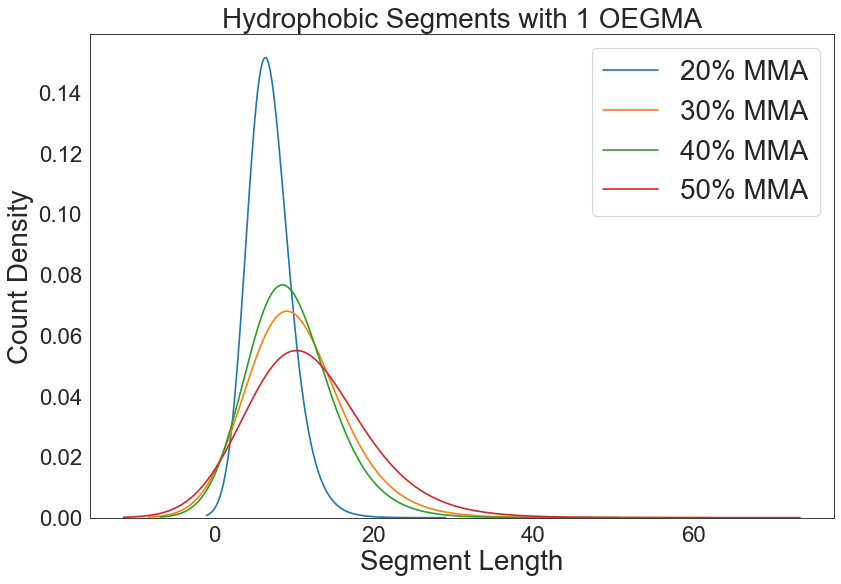

In [179]:
#analyzes specific segment search data
Avg_NumSeg = np.mean(np.array(seg_len_list))
StDev_NumSeg = np.std(np.array(seg_len_list))
Avg_LenSeg = []
StDev_LenSeg = []

for i in range(len(seg_array_b)):
    if seg_array_b[i] != []:
        avg = np.mean(np.array(seg_array_b[i]))
        sdev = np.std(np.array(seg_array_b[i]))
        Avg_LenSeg.append(avg)
        StDev_LenSeg.append(sdev)

print("Average Number of Hydrophobic segments with 1 Oegma per sequence in batch: " + str(Avg_NumSeg))
print("StDev of Number of Hydrophobic segments with 1 Oegma per sequence in batch: " + str(StDev_NumSeg))
#Uncomment following lines for length data per sequence
#print("Average lengths of Hydrophobic segments with 1 OEGMA per sequence in batch: " + str(Avg_LenSeg))
#print("StDev of lengths of Hydrophobic segments with 1 Oegma per sequence in batch: " + str(StDev_LenSeg))

plt.cla()   # Clear axis
plt.clf()   # Clear figure
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
sns.set_style(style='white') #style='white' or 'darkgrid'
plt.xlabel("Segment Length")
plt.ylabel("Count Density")
sns.set_style(style = 'white')
#Comment following lines to remove autolabelling
for i in range(len(csv_files)):
    sns.distplot(total_array[i], label=str((i+2)*10)+"% MMA",hist = False, kde_kws={'bw':1})
    plt.legend()
## Uncomment to label manually
#sns.distplot(total_array[0], label="5 Monomers", hist=False, kde_kws={'bw':1})
# sns.distplot(total_array[1], label="4 Monomers",hist = False)
# sns.distplot(total_array[2], label="2 Monomers",hist = False)
# sns.distplot(total_array[3], label="3 Monomers",hist = False)
# plt.legend()
plt.title("Hydrophobic Segments with 1 OEGMA")
plt.show()

### Sliding Window Analysis
EXTRA VARIABLE: window_length (note window_length >= FILT otherwise you will encounter errors if you try average a window longer than the shortest chain in a batch)
- mon2mon: sliding window on a single chain --> hydropathy plot
- seq2seq: box-whisker plot showing statistics along the positions of a chain, then average over positions
- batch2batch: TODO-plot position averaged statistics from seq2seq on some kind of plot you can compare between batches

In [54]:
### SLIDING WINDOW ANALYSIS OF POLYMERS
# Set window length:
WIN_LENGTH = 10

# create a new list bins, to replace amino acids by corresponding hydrophobicity over the whole sequence 
def translate(chars, HLBs):
    bins = []
    for i in range(len(chars)):
        bins.append(HLBs[int(chars[i])-1])
    return bins

# iterate an iterable sequence by the number of size per time and create a list of sliding_Arrays for that
def window( iterable, size ):
    sliding_array=[]
    iters = tee(iterable, int(size))
    for i in range(1, int(size)):
        for each in iters[i:]:
            next(each, None)
    for each in zip(*iters):
        sliding_array.append(list(each))
    return sliding_array

# create a dictionary to keep the medium coordinate and average value for each sliding window
def seg_analysis(sliding_arrays,win_length):
    pos_val={}  
    int_pos = int(win_length) // 2 +1
    for each in sliding_arrays:
        ave_value=np.mean(each)
        pos_val[int_pos]=ave_value
        int_pos+=1
    return pos_val

#input a dictionary including positions and average value of a sliding arrays, output a plot
def win_plot(pos_val, pro_name, win_length, inverse=False):
    # sorted by key, return a list of tuples
    lists = list(sorted(pos_val.items())) 
    # unpack a list of pairs into two tuples
    x, y=zip(*lists)
    # Create a Figure
    fig =plt.figure(figsize=(8,8))
    # Set up Axes
    ax= fig.add_subplot(111)
    if inverse:
        plt.ylim((5,13))
        plt.gca().invert_yaxis()
    ax.scatter(x, y)
    ax.plot(x, y)
    #ax.set_xlim(0, 60)
    ax.set(title= "Hydropathy plot of " + str(pro_name) + " ,window length = " + str(win_length), xlabel="Center AA in AAs window", ylabel="Average Hydrophobicity/Window")
    #plt.savefig("outputs/" + str(pro_name) + "_" + str(win_length) + ".png",transparent =True)
    plt.show()

"""
# ACTUAL SCRIPT.
for m in tqdm_notebook(range(len(csv_files))):
    
    filename = csv_files[m].replace(path, '').replace('/', '').replace('.csv', '')

    mat = list()
    for seq in tqdm_notebook(seqs[m]):
        bins = translate(seq, HLBs)
        sliding_arrays = window(bins, WIN_LENGTH)
        pos_val = seg_analysis(sliding_arrays, WIN_LENGTH)
        lists = list(sorted(pos_val.items()))
        x,y = zip(*lists)

        mat.append(y)
            
    df = pd.DataFrame(mat)
    #r"outputs/HLB_%s.xlsx"%filename
    df.to_csv(r'outputs/%s_%s_%d.csv'% (filename,"HLB",int(WIN_LENGTH)),index=False)
""";

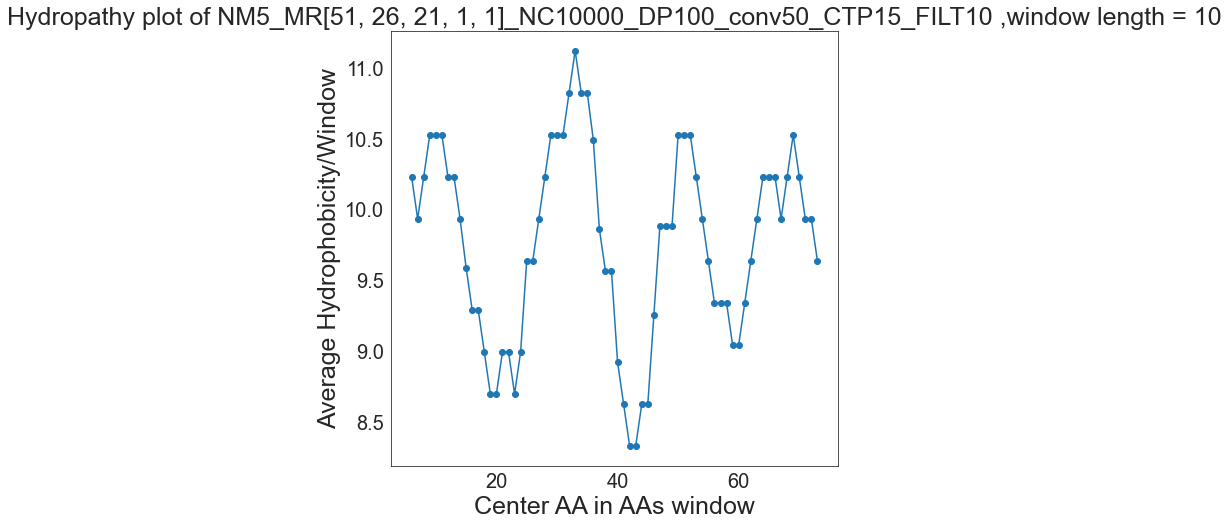

In [55]:
batch_num = 2
sequence_num = 1982
"""
filename = csv_files[m].replace(path, '').replace('/', '').replace('.csv', '')
i = 0
for seq in tqdm_notebook(seqs[m]):
    if i == sequence_num:
        
        bins = translate(seq, HLBs)
        sliding_arrays = window(bins, WIN_LENGTH)
        pos_val = seg_analysis(sliding_arrays, WIN_LENGTH)
        win_plot(pos_val, filename, WIN_LENGTH)
    i = i + 1
"""

this_seq = [int(x) for x in dfs[batch_num].iloc[sequence_num] if x != None]
bins = translate(this_seq, HLBs)
sliding_arrays = window(bins, WIN_LENGTH)
pos_val = seg_analysis(sliding_arrays, WIN_LENGTH)
win_plot(pos_val, filename, WIN_LENGTH)

In [90]:
#get HLB files of a particular window length
"""
path = "outputs"
hlb_csv_files = []
for file in os.listdir(path):
    if file.endswith("HLB_%d.csv"% (int(WIN_LENGTH))):
        hlb_csv_files.append(os.path.join(path, file))
hlb_csv_files = sorted(hlb_csv_files)
print("Number of sequence files:", len(hlb_csv_files))
print(hlb_csv_files)
"""

dfs_hlb = []
seq_lens_hlb = []
for d in tqdm_notebook(range(len(csv_files))):
    mat = list()
    for seq in tqdm_notebook(seqs[d]):
        bins = translate(seq, HLBs)
        sliding_arrays = window(bins, WIN_LENGTH)
        pos_val = seg_analysis(sliding_arrays, WIN_LENGTH)
        lists = list(sorted(pos_val.items()))
        x,y = zip(*lists)

        mat.append(y)
    dfs_hlb.append(pd.DataFrame(mat))
    seq_lens_hlb.append(row_size)

"""
# read sliding window analysis csv files and convert to pd dataframes
dfs_hlb = []
seq_lens_hlb = []
batch2batch_arr = []

for m in range(len(csv_files)):
    seq = []
    row_size = []
    
    with open(hlb_csv_files[m], mode = 'r') as file:
        csvFile = csv.reader(file)
        i = 0
        for lines in csvFile:
            i = i + 1
            if i > 1:
                seq.append(lines)
                row_size.append(len(lines))
        df = pd.DataFrame(seq)
        dfs_hlb.append(df)
        seq_lens_hlb.append(row_size)
""";


rows size: 10000
cols size: 287


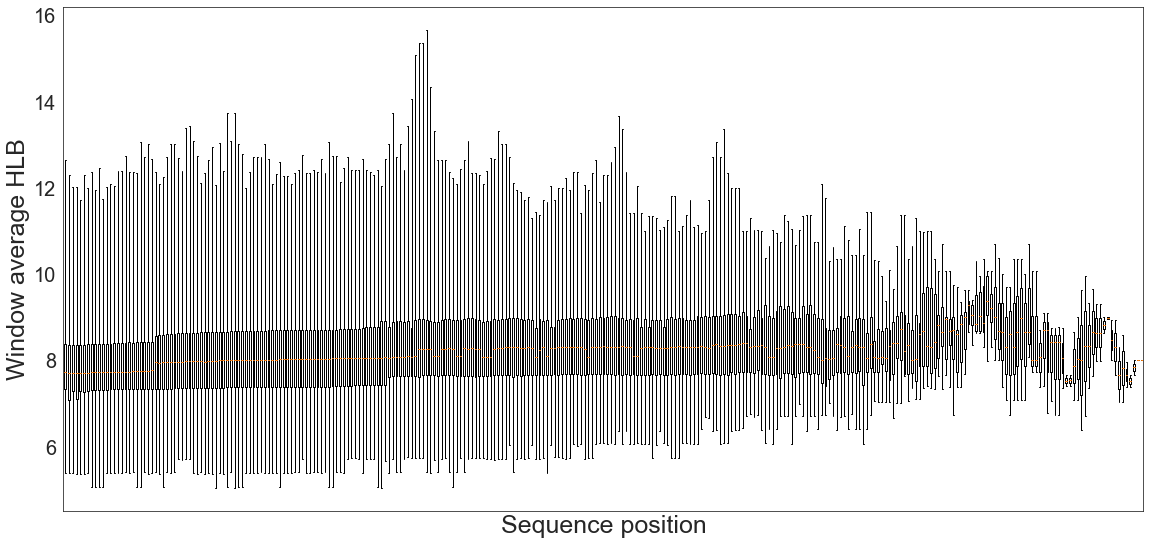

rows size: 10000
cols size: 265


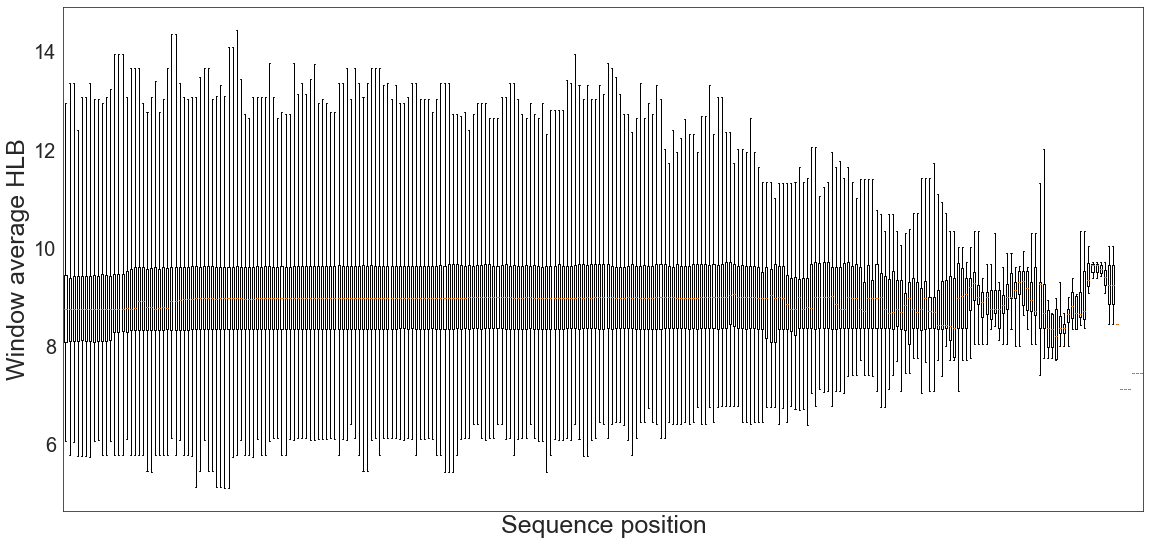

rows size: 9999
cols size: 290


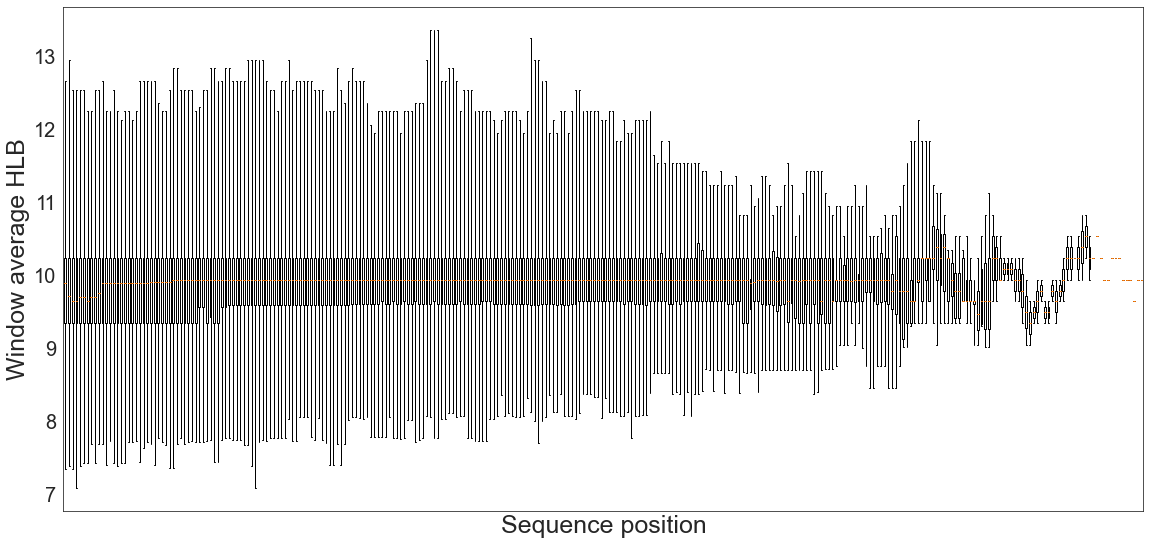

rows size: 10000
cols size: 269


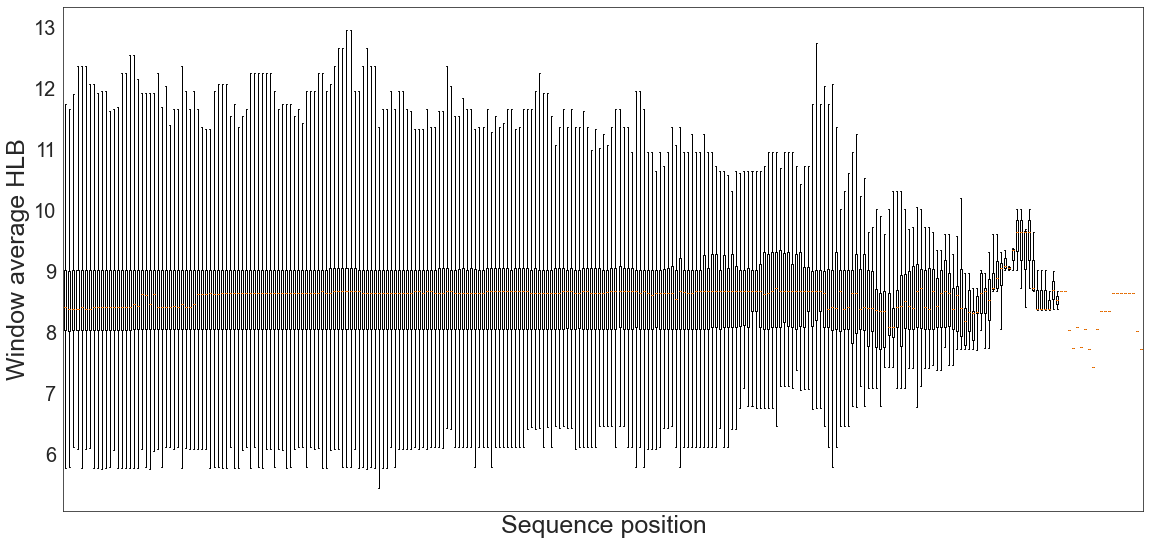

In [91]:
batch2batch_arr = []
for batch_ind in tqdm_notebook(range(len(csv_files))):

    rows_size = len(dfs_hlb[batch_ind])
    print("rows size:", rows_size)
    cols_size = len(dfs_hlb[batch_ind].columns)
    print("cols size:", cols_size)

    #Box Whisker Plot of Sliding Window Analaysis Data

    pos_data = list()
    datacol_array = np.zeros(5)
    for i in range(cols_size):
        datacol = [y_ for y_ in dfs_hlb[batch_ind][i] if y_ > 0]
        datacol_array[4] += np.amax(np.array(datacol))
        datacol_array[0] += np.amin(np.array(datacol))
        datacol_array[2] += np.mean(np.array(datacol))
        datacol_array[3] += np.percentile(np.array(datacol), 75)
        datacol_array[1] += np.percentile(np.array(datacol), 25)
        pos_data.append(datacol)
    
    batch2batch_arr.append(datacol_array/cols_size)

    fig = plt.figure(figsize =(15, 7))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.boxplot(pos_data, whis=(0,100))
    plt.xlabel("Sequence position")
    plt.ylabel("Window average HLB")
    plt.xticks([])
    #plt.xticks(np.arange(0,cols_size, step=20)) #TODO: fix x axis marks
    plt.show()
    

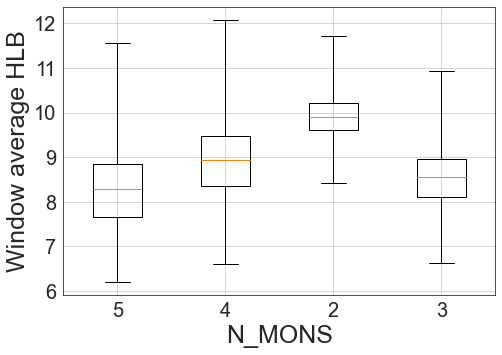

In [92]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.boxplot(batch2batch_arr, whis=(0,100))
plt.xlabel("N_MONS")
plt.ylabel("Window average HLB")
plt.xticks([1, 2, 3, 4], [5, 4, 2, 3]) #Change second arrays with labels
plt.grid(None)
plt.show()